# Visualizing descriptive statistics and applying regression models to meteorological data knowledge graph WeKG-MF. 
#### maintained by the [WIMMICS team](https://team.inria.fr/wimmics/)

This notebook demonstrates how to access and query WeKG-MF RDF dataset and visualize the geographical and time series data resulting from a query. In this notebook we are going to visualize descriptive statistics and explore dependencies and correlations between the weather variables.


The WeKG-MF dataset offers access to a large set of meteorological variables described through spatial and temporal dimensions. 


The full description of the dataset can be found here: https://github.com/Wimmics/weather-kg/tree/main/meteo. 

SPARQL query endpoint: http://weakg.i3s.unice.fr/sparql.

**REFERENCES:**

Nadia Yacoubi Ayadi, Catherine Faron, Franck Michel, Fabien Gandon, Olivier Corby. WeKG-MF: a Knowledge Graph of Observational Weather Data. ESWC 2022 - 19th Extended Semantic Web Conference, May 2022, Hersonissos, Greece. https://hal.inria.fr/hal-03657694/file/WeKG-MF-Poster-ESWC-2022.pdf

Bevans, R. (2022, May 06). Linear Regression in R | An Easy Step-by-Step Guide. Scribbr. Retrieved November 16, 2022, from https://www.scribbr.com/statistics/linear-regression-in-r/

In [46]:
R.Version()$version

[1] "R version 4.1.3 (2022-03-10)"

## Setup


NOTE: If you are running this notebook in Google Colab it may take a long time to install some packages, for example, we've observed that installing packages `leaflet` and `treemap` takes 8 and 5 minutes respectively. At the moment we didn't find a remedy for this. Please be patient, have a cup of tea 🍵.

### Enable querying of the Knowledge Graph  
The easiest way to access and query the dataset endpoint is to use the R package [SPARQL](https://cran.r-project.org/web/packages/SPARQL/index.html). However, it was recently removed from the CRAN repository but still can be installed from the archive. 

Alternatively, use this work: https://ourednik.info/maps/2021/12/14/execute-sparql-chunks-in-r-markdown/ .

In [47]:
options(warn=-1) # to turn warnings back on use options(warn=0)

if (!require(SPARQL)) {
  install.packages("XML", quiet=TRUE)
  install.packages("RCurl", quiet=TRUE)
  install.packages("https://cran.r-project.org/src/contrib/Archive/SPARQL/SPARQL_1.16.tar.gz",
                    repos=NULL, type="source",  quiet=TRUE)
}
library(SPARQL)  

### Define dataset endpoint for the SPARQL data access

NOTE: depending on the runtime environment an *https* endpoint URL may lead to an error. In this case, try to change it to *http*.

In [48]:
endpoint <- "http://weakg.i3s.unice.fr/sparql"
options <- NULL

### Define prefixes to abbreviate namespaces

The first set of prefixes is used in the SPARQL query and the second to abbreviate the returned data.

In [49]:
sparql_prefix <- '
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

PREFIX qudt: <http://qudt.org/schema/qudt/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX geosparql:  <http://www.opengis.net/ont/geosparql#> 
PREFIX qb: <http://purl.org/linked-data/cube#>
PREFIX sosa: <http://www.w3.org/ns/sosa/>

PREFIX weo: <http://ns.inria.fr/meteo/ontology/>
PREFIX wep: <http://ns.inria.fr/meteo/ontology/property/>
PREFIX wevp: <http://ns.inria.fr/meteo/vocab/weatherproperty/>
PREFIX wes-dimension: <http://ns.inria.fr/meteo/observationslice/dimension#>
PREFIX wes-measure: <http://ns.inria.fr/meteo/observationslice/measure#>
PREFIX wes-attribute: <http://ns.inria.fr/meteo/observationslice/attribute#>
'

data_prefix <- c('wekg','<http://ns.inria.fr/meteo/>', 
                 'wevp', '<http://ns.inria.fr/meteo/vocab/weatherproperty/>',
                 'wd',   '<http://www.wikidata.org/entity/>',
                 'wdt',  '<http://www.wikidata.org/prop/direct/>',
                 'qudtu', '<http://qudt.org/vocab/unit/>')

### Enable visualization tools
The easiest way to visualize a map would be to use `ggmap` package. However, now it requires the use of an API key that only allows a certain number of API calls and is not suited for our purposes. The next best thing is  [Leaflet for R](https://rstudio.github.io/leaflet/) which is a wrapper over the popular Javascript library. 

NOTE: Running this notebook in the Google Colab environment prevents the rendering of the Leaflet's map widget to the output. The workaround would be to save it as HTML and render it in an *iframe* as described in https://stackoverflow.com/questions/67552710/how-to-display-interactive-leaflet-map-in-r-notebook-in-colab/67573334#67573334.


In [50]:
# in the case of version incompatibility uncomment the line below
#remove.packages("htmltools")

if (!require(leaflet, quietly=TRUE)) {
  install.packages("leaflet", , Ncpus=parallel:::detectCores())
}
library(leaflet)
library(htmlwidgets)
library(htmltools)  

if  (!require(IRdisplay, quietly=TRUE))  install.packages("IRdisplay")
library(IRdisplay)

isColab <- nchar(Sys.getenv("GCE_METADATA_TIMEOUT")) > 0

# Helper functions that help rendering of the widgets  
# both natively and in the iframe
encode_widget <- function (widget) {
    widget<-gsub("%","%25",widget)
    widget<-gsub("#","%23",widget)
    widget<-gsub("\"","%22",widget)
    widget<-gsub("'" ,"%27",widget)
    widget<-gsub("\\n" ,"",widget)
    widget<-paste(widget, collapse="")
    return(widget)
}

widget2html <- function (widget, file='widget.html') {
    saveWidget(widget, file, selfcontained = TRUE)
    demo<-readLines(file)
    demo<-encode_widget(demo)

    return(demo)
}

widget2iframe <- function (widget, width="100%", height="100%")
{
    iframe.html <- '<iframe src="data:text/html;charset=UTF-8, %s" width="%s" height="%s"></iframe>'  
    iframe.html <- sprintf(iframe.html, widget2html(widget),
                            width, height)
    return(iframe.html)
}

show_widget <- function (widget ,  width="100%", height="100%")
{
  if (isColab) { 
      
    iframe.html <- widget2iframe(widget, width, height)
    display_html(iframe.html)

  } else {
    widget
  }
}

For charting of the data we will be using: 
-  `gglpot2` that will allow creating graphs that represent both univariate and multivariate numerical and categorical data
- `treemap` for space-filling visualization
- `ggbiplot` for ploting PCA results

In [51]:
if (!require(treemap, quietly=TRUE)) {
  install.packages("treemap", , repos="https://mirror.ibcp.fr/pub/CRAN/", quiet=TRUE)
}
library(treemap)
library(ggplot2)

if (!require("RColorBrewer"))  install.packages("RColorBrewer")
library(RColorBrewer)

if (!require(ggbiplot)) {
  library(devtools)
  install_github("vqv/ggbiplot")
}
library(ggbiplot)

### Enable regression tools

For efficient fitting of linear regression and *LASSO* we'll use `glmnet` package. 

In [52]:
if (!require(glmnet, quietly=TRUE))  install.packages("glmnet" , quiet = TRUE)
library(glmnet)

### Enable data manipulation tools

For easy manipulations of timed data we use `tsbox` package. Another handy function *melt* comes from `reshape2` package.


In [53]:
if (!require(tsbox, quietly=TRUE)) {
    install.packages("tsbox" , quiet = TRUE)
}
library(tsbox)

if (!require(reshape2, quietly=TRUE)) install.packages("reshape2" , quiet = TRUE)
library(reshape2)

The setup is done. 

## Visualizing weather stations locations
The dataset has information about the location of the weather stations. Let's query the dataset for the list of French weather stations, their geographical coordinates, and administrative regions.

In [54]:
query_stations <- '
# wdt:P131 = located in the administrative territorial entity
# wdt:P2585 = INSEE region code

SELECT distinct * 
WHERE {
        ?station  a weo:WeatherStation;
                  rdfs:label ?stationName;
                  geo:lat ?lat; geo:long ?long.
             
         OPTIONAL {?station dct:spatial/wdt:P131 ?region.
                   ?region rdfs:label ?regionLabel;
                           wdt:P2585 ?regionCode.}
}
ORDER BY ?regionCode ?stationName
'

query_stations <- paste(sparql_prefix, query_stations)

stations <- SPARQL(url= endpoint,
              query = query_stations,
              ns=data_prefix,
              extra=NULL)$results

print(paste('Result rows:', nrow(stations)))

[1] "Result rows: 61"


In [87]:
options(repr.plot.width = 16)
options(repr.plot.height = 8)
options(repr.plot.align = 'left')

big.map <- leaflet(data=stations, width="100%", #height = "610px", width
                     options = leafletOptions(minZoom = 1, maxZoom= 6 )) %>% 
  addTiles() %>% 
  addControl("Meteo France Weather Stations", position = "bottomleft")  %>%
  addMarkers(~long, ~lat, popup= ~stationName)

show_widget(big.map, height = "400px")
#display_png(file="plot.png) # widget printing does not work - use this to print 
print("click on a marker to open stataion name label...")

HTML widgets cannot be represented in plain text (need html)

[1] "click on a marker to open stataion name label..."


TODO: 
- figure out how to read the name of the station from the widget

## Exploring data from a selected weather station

Query the amount of available data for a station. This might be useful in deciding which weather properties we can analyze. 

Copy/paste the station name from the marker label on the map above for the station you are interested in.

In [56]:
station_name <- "NICE"

In [57]:
query_properties <- '
SELECT ?prop  (MIN(?result) AS ?min_value)
              (MAX(?result) AS ?max_value)
              (AVG(?result) AS ?avg_value)
              (SAMPLE(?prop_unit) AS ?unit)
              (MIN(?time) AS ?min_time) 
              (MAX(?time) AS ?max_time) 
              (COUNT(DISTINCT ?obs) AS ?datapoints_count)
              (COUNT(DISTINCT ?date) AS ?days_count)
              (COUNT(DISTINCT ?year) AS ?years_count)
              (GROUP_CONCAT(DISTINCT ?interval; SEPARATOR=", ") AS ?intervals)

WHERE {
    VALUES (?stationName) {("%s")}
    ?stationIRI rdfs:label ?stationName.

    ?obs a weo:MeteorologicalObservation;
          wep:madeByStation  ?stationIRI;  
          sosa:observedProperty ?prop ;
          sosa:resultTime ?time ;
          sosa:hasSimpleResult ?result .

     OPTIONAL {?prop skos:prefLabel ?propLabel.}

     OPTIONAL{ ?obs sosa:phenomenonTime [ a ?interval ]. }
     OPTIONAL {?prop qudt:applicableUnit ?prop_unit. }

     BIND(xsd:date(SUBSTR(STR(?time), 1,10)) AS ?date )
     BIND(YEAR(?time) AS ?year )
}
GROUP BY ?prop 
'
query_properties <- sprintf( query_properties, station_name)
query_properties <- paste(sparql_prefix, query_properties)

weather_props <- SPARQL(url= endpoint,
              query = query_properties,
              ns=data_prefix,
              extra=NULL)$results

print(paste('Result rows:', nrow(weather_props)))

[1] "Result rows: 18"


In [58]:
# convert date from numeric representation returned from query to R's date format
weather_props$min_time <- as.POSIXct(weather_props$min_time, origin="1970-01-01")
weather_props$max_time <- as.POSIXct(weather_props$max_time, origin="1970-01-01")

# strip prefix to shorten the text and create lables with counts
weather_props$prop_label <- paste(substring(weather_props$prop, nchar("wevp:") +1 ), "\n", 
                                    weather_props$datapoints_count, " obs", "\n", 
                                    weather_props$days_count, " days")

#weather_props

### Visualize the number of observations per weather property

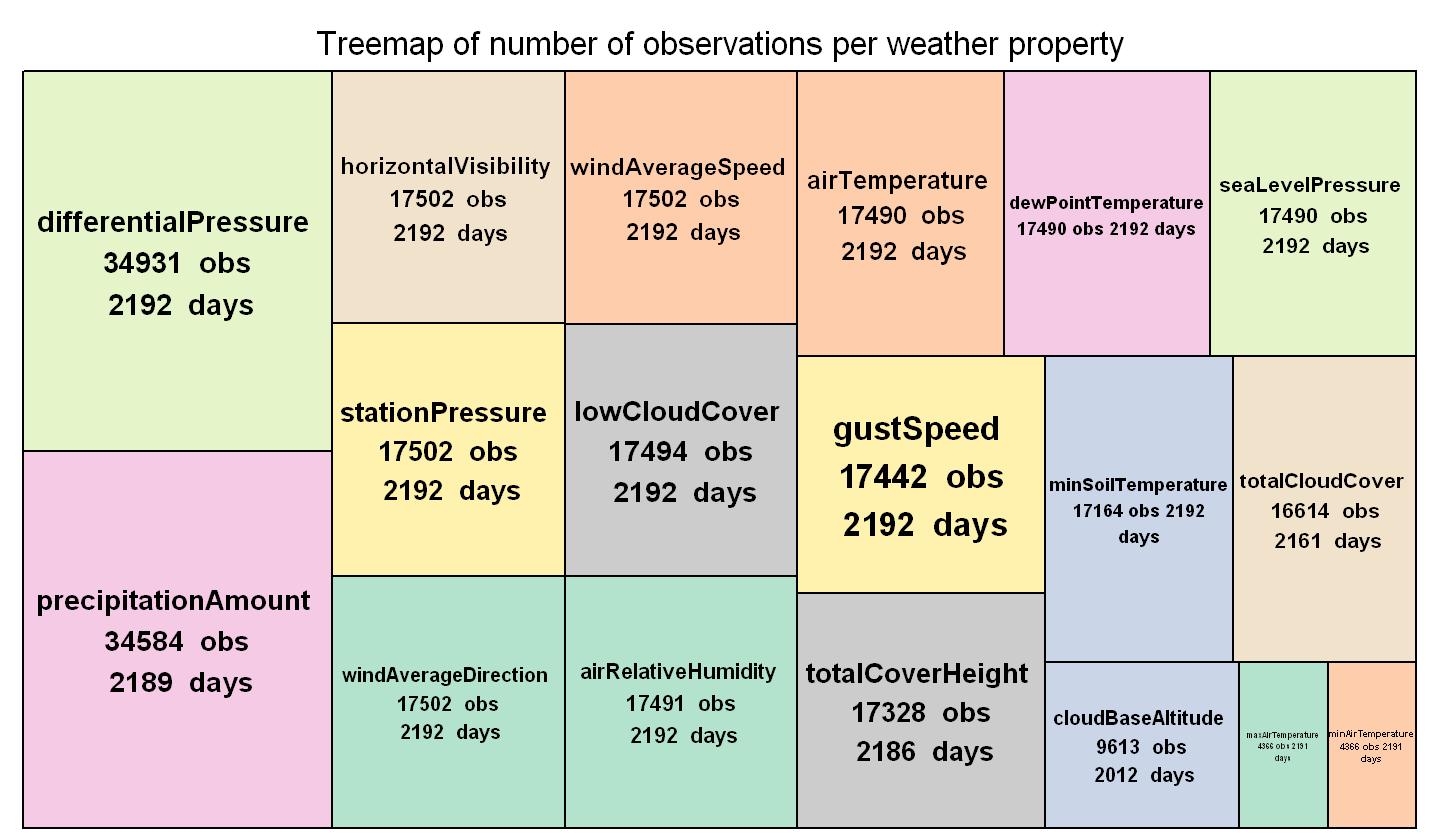

In [59]:
options(repr.plot.width = 12)
options(repr.plot.height = 7)
options(repr.plot.align = 'left')

tm <-treemap(weather_props,
            index="prop_label",
            vSize="datapoints_count",
            type="index",
            palette="Pastel2",
            fontsize.labels=20,
            inflate.labels = FALSE,
            title="Treemap of number of observations per weather property",
            fontsize.title=c(20),
            #aspRatio=3/2,
            vp=grid::viewport(width=grid::unit(12, 'inch'), height=grid::unit(7, 'inch')) 
            )

From looking at this treemap we can work out that: 
- majority of the observations are taken 8 times a day (every 3 hours) during 2189 days (6 years)
- 2 properties *minAirTemperature* and *minAirTemperature* are the aggregates of temperature for a day taken 2 times a day
- 2 properties *cloudBaseAltitude*, *totalCloudCover* are missing  more than 10 days of observations
- 2 properties *percipitationAmount* and *diffrentialPressure* observations are recorded twice at the same time and represent cumulative values or differences respectively for 3 hours and 12 hours.


### Visualize the range of values  for each weather property

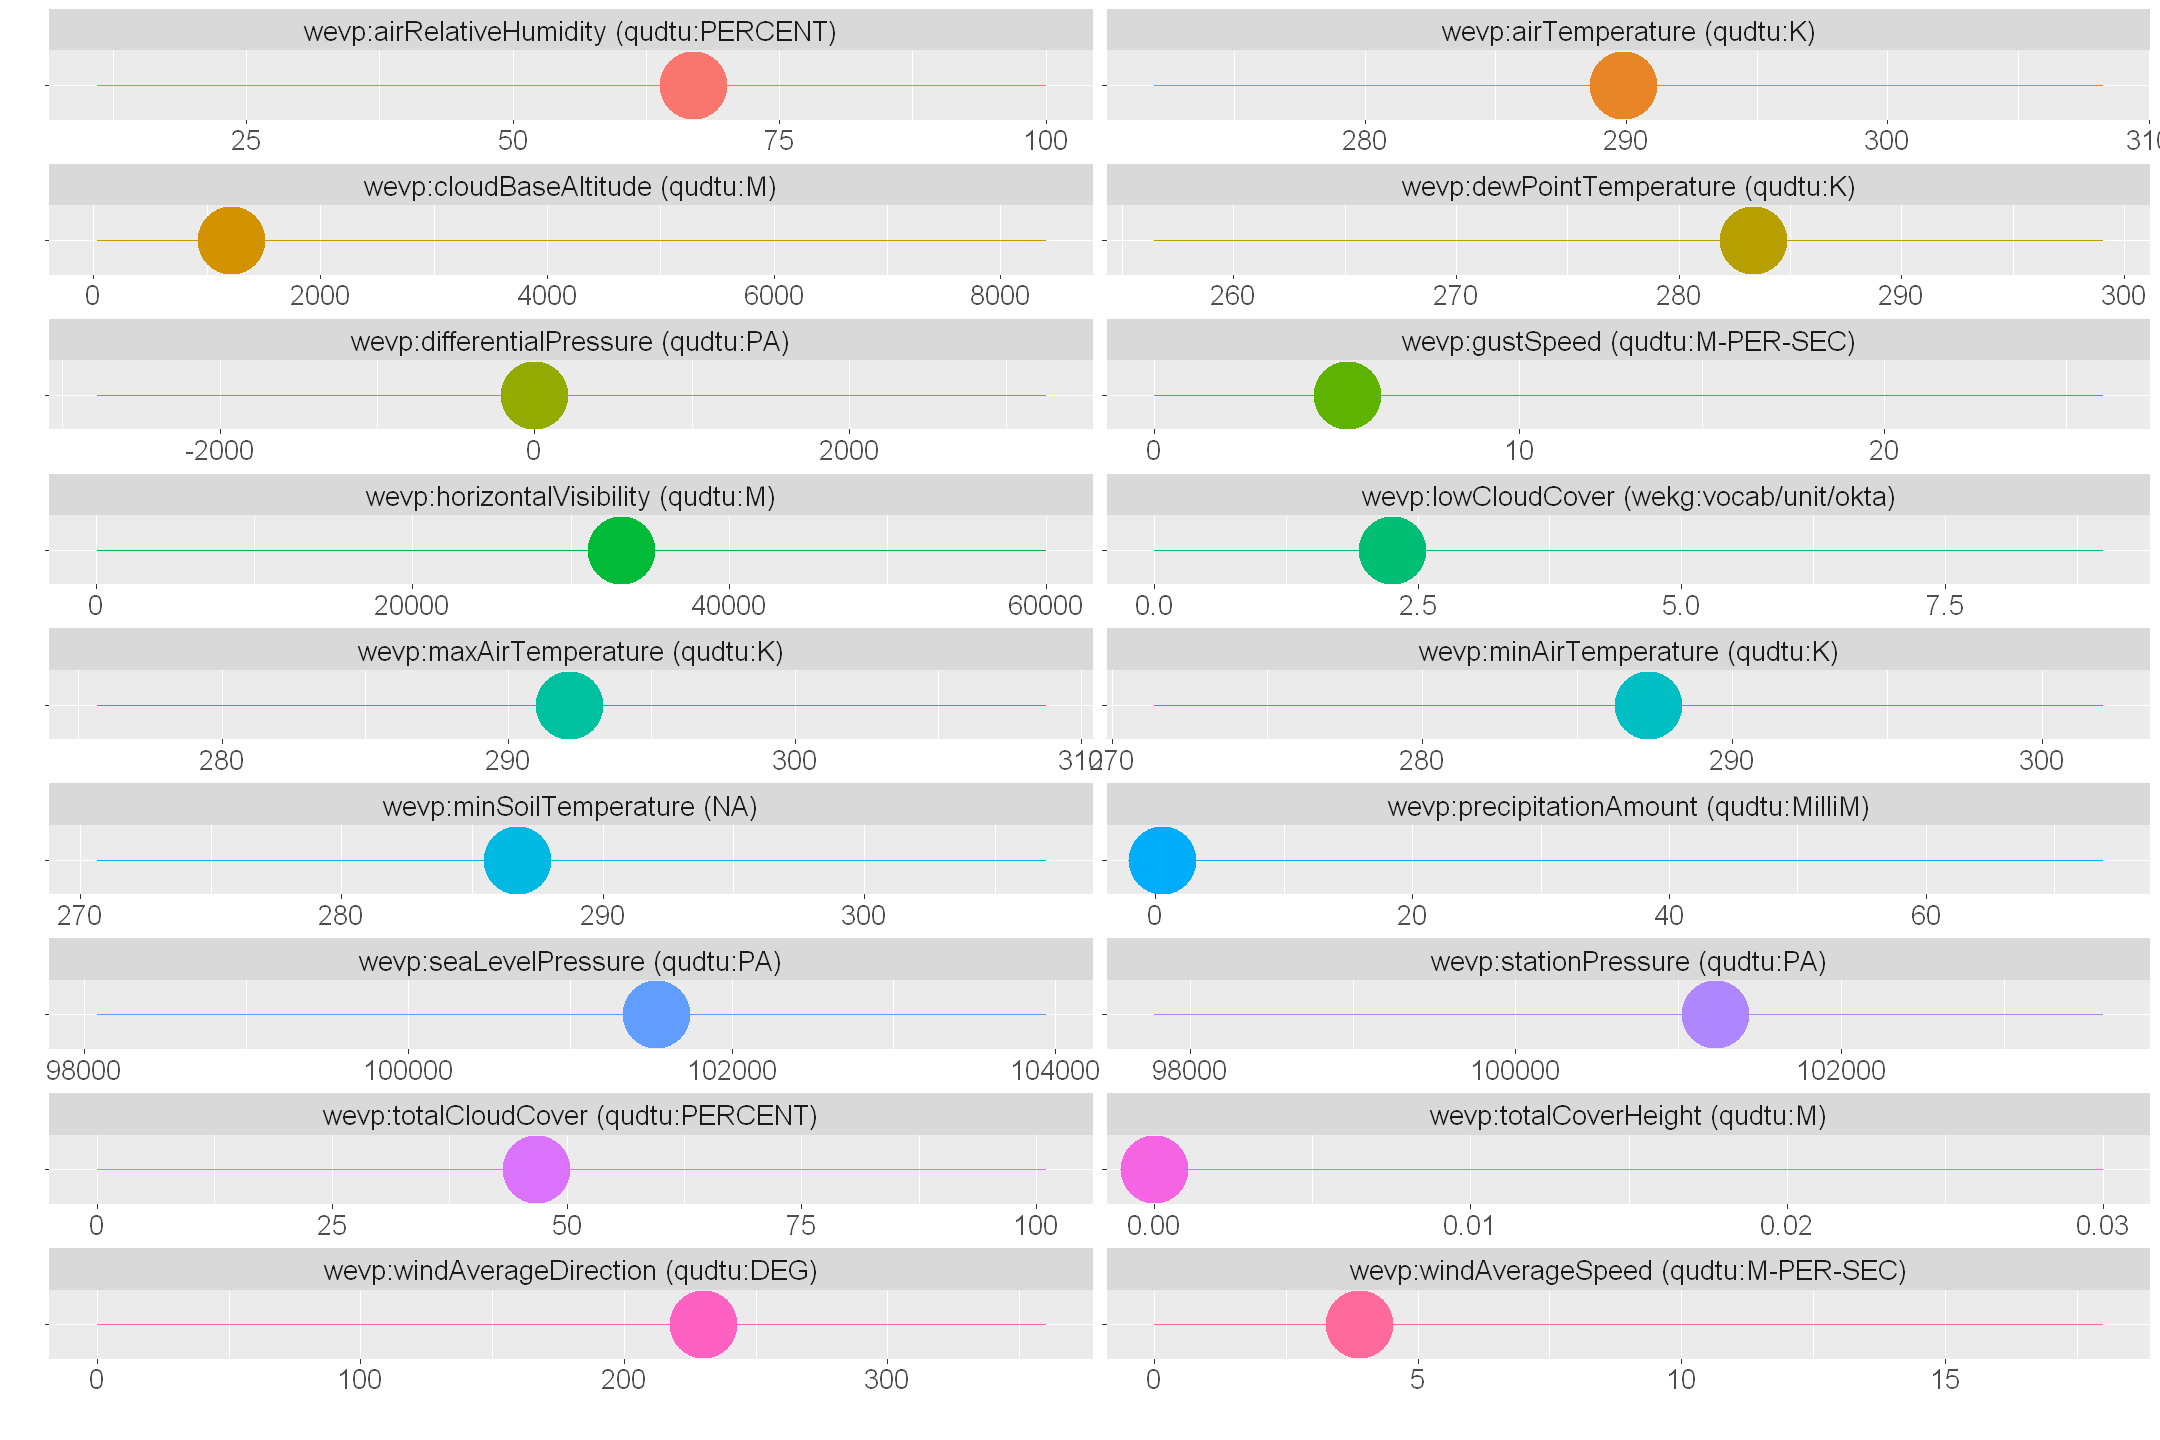

In [60]:
options(repr.plot.width = 18)
options(repr.plot.height = 12)
options(repr.plot.align = 'left')

prop.labels <- sprintf("%s (%s)" , weather_props$prop, weather_props$unit ) 
names(prop.labels) <- weather_props$prop

ggplot(data = weather_props, mapping = aes(x = prop, y = avg_value , col=prop) )  +
    geom_pointrange(aes(ymin = min_value, ymax = max_value, size=0.1)) + 
    xlab("") +
    ylab("") +
    theme(text = element_text(size=20), 
          legend.position="none", 
          axis.text.y= element_blank()) + 
    facet_wrap(~prop, nrow= ceiling(nrow(weather_props) / 2), ncol=2, 
               strip.position = "top",
               scale="free",
                labeller = as_labeller(prop.labels) ) +
    coord_flip()

## Hypothesis Testing with Linear Regression

Intuitively we assume that air temperature might be dependent on other weather factors like relative humidity or/and wind speed. We can test this hypothesis (or rather the null hypothesis that there is no significant relationship) by trying to detect a linear relationship between *airTemperature* and *airRelativeHumidity* and/or *windAverageSpeed*.  

### Query values for selected weather properties

The data server returns a maximum of 50,000 rows of data so we cannot request all the data at once. We can either 
- use a loop with LIMIT and OFFSET clauses (not discussed here) or 
- take one year of measurements using FROM to restrict queriable graphs (current query) or
- or we can get as much data as we can from the beginning of the observation time (comment FROM clauses)

In [61]:
query_properties_data <- '
SELECT ?prop  ?time ?value

FROM <http://ns.inria.fr/meteo/observation/2016>
FROM <http://ns.inria.fr/meteo/weatherstation>

WHERE {
    VALUES (?stationName) {("%s")}
    VALUES (?prop) { ( wevp:airTemperature ) 
                     #( wevp:airRelativeHumidity )
                     ( wevp:windAverageSpeed ) }
    ?stationIRI rdfs:label ?stationName.

    ?obs a weo:MeteorologicalObservation;
          wep:madeByStation  ?stationIRI;  
          sosa:observedProperty ?prop ;
          sosa:resultTime ?time ;
          sosa:hasSimpleResult ?value.

     BIND(xsd:date(SUBSTR(STR(?time), 1,10)) AS ?date )
     BIND(YEAR(?time) AS ?year )
}
ORDER BY ?time
'

query_properties_data <- sprintf( query_properties_data, station_name)
query_properties_data <- paste(sparql_prefix, query_properties_data)

weather_data <- SPARQL(url= endpoint,
              query = query_properties_data,
              ns=data_prefix,
              extra=NULL)$results

# convert date from numeric representation returned from query to R's date format
weather_data$time <- as.POSIXct(weather_data$time, origin="1970-01-01")

# remove prefix from the property names to make life easier 
# when property names will become column names
weather_data$prop <- sapply(weather_data$prop, FUN=function(x) gsub("^.*?:", "", x) )

print(paste('Result rows:', nrow(weather_data)))

[1] "Result rows: 5839"


We want to have the data points for each weather property aligned on the time scale. We can take advantage of *wide* time series format, where each row represents a time point with all the weather properties values. As opposed to the *long* format where each value has a row like a result of the query. 

It is convenient to go from one format to another as different functions work better with different representations.

In [62]:
options(width=80)

weather_data.wide <- ts_wide(weather_data)

summary(weather_data.wide)

      time                     airTemperature  windAverageSpeed
 Min.   :2016-01-01 00:00:00   Min.   :276.2   Min.   : 0.00   
 1st Qu.:2016-04-01 06:45:00   1st Qu.:284.9   1st Qu.: 2.50   
 Median :2016-07-02 04:30:00   Median :289.4   Median : 3.60   
 Mean   :2016-07-01 23:07:58   Mean   :289.8   Mean   : 4.04   
 3rd Qu.:2016-10-01 11:15:00   3rd Qu.:295.1   3rd Qu.: 5.00   
 Max.   :2016-12-31 21:00:00   Max.   :305.9   Max.   :17.20   
                               NA's   :5                       

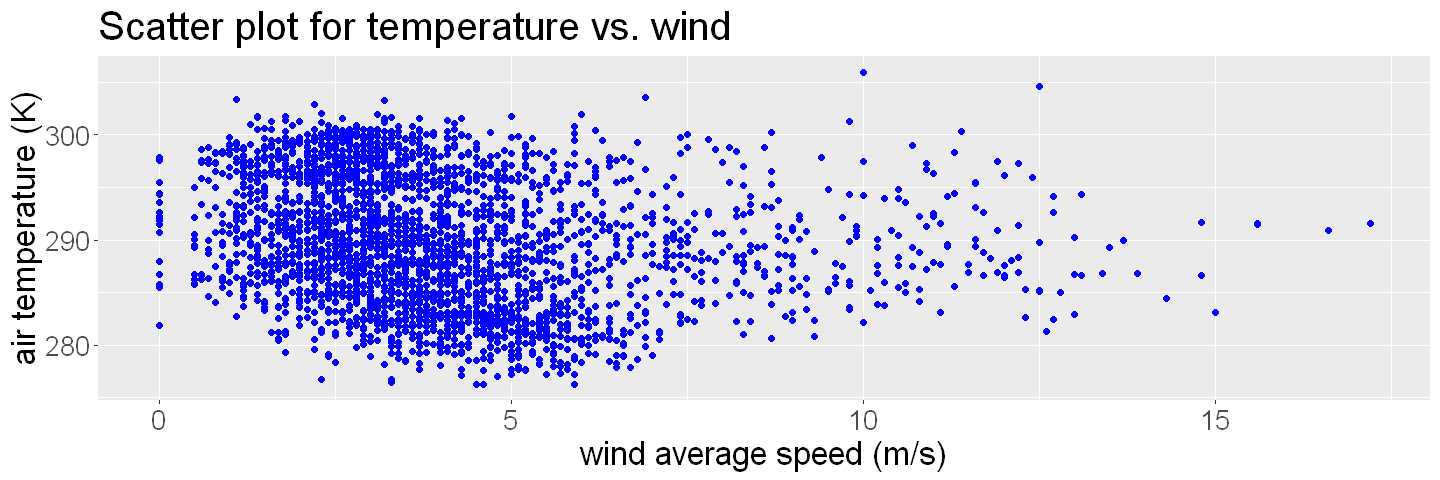

In [63]:
options(repr.plot.width = 12)
options(repr.plot.height = 4)
options(repr.plot.align = 'left')

# refactor
column.labels = c("airTemperature" = "Temperature (K)",
                  "airRelativeHumidity"="Relative Humidity (%)",
                  "windAverageSpeed" = "Average Wind Speed (m/sec)") 

library(scales)
column.colors = hue_pal()(length(column.labels))
names(column.colors) <- sort(names(column.labels))


ggplot(weather_data.wide, aes(x=windAverageSpeed, y=airTemperature )) +
       geom_point(color="blue" ) +
       theme(text = element_text(size=20) ) + 
       ggtitle("Scatter plot for temperature vs. wind") +
       xlab("wind average speed (m/s)")  + 
       ylab("air temperature (K)")

### Handle missing values
Perhaps not all of the time points have all the weather property values. We can identify them and if there are only a few we can drop them.

In [64]:
print("MISSING VALUES")

weather_data.wide [rowSums(is.na(weather_data.wide)) > 0, ]

# drop missing values
weather_data.wide <- na.omit(weather_data.wide)

[1] "MISSING VALUES"


,time,airTemperature,windAverageSpeed
,<dttm>,<dbl>,<dbl>
393,2016-02-19 00:00:00,NA,4.0
445,2016-02-25 12:00:00,NA,2.4
446,2016-02-25 15:00:00,NA,5.0
2614,2016-11-23 09:00:00,NA,12.7
2615,2016-11-23 12:00:00,NA,14.2


In [65]:
# reshape to a "long" format
weather_data.long <- ts_long(weather_data.wide )
      
print(paste('Wide format rows:', nrow(weather_data.wide)))
print(paste('Long format rows:', nrow(weather_data.long)))

[1] "Wide format rows: 2917"
[1] "Long format rows: 5834"


### Handle outliers

Outliers increase the variability in the data, which decreases statistical power. Some outliers represent natural variations in the measurements, and they should be left in the dataset. These are called true outliers. Other outliers can represent measurement errors, data entry or processing errors, or poor sampling and should be removed from the dataset. 

For example, intuitively we know that a strong wind is a rear event in many parts of France and is not representative of normal weather. 

For simplicity reasons, we can remove all of the outliers using the interquartile range method provided by ```boxplot``` functionality.

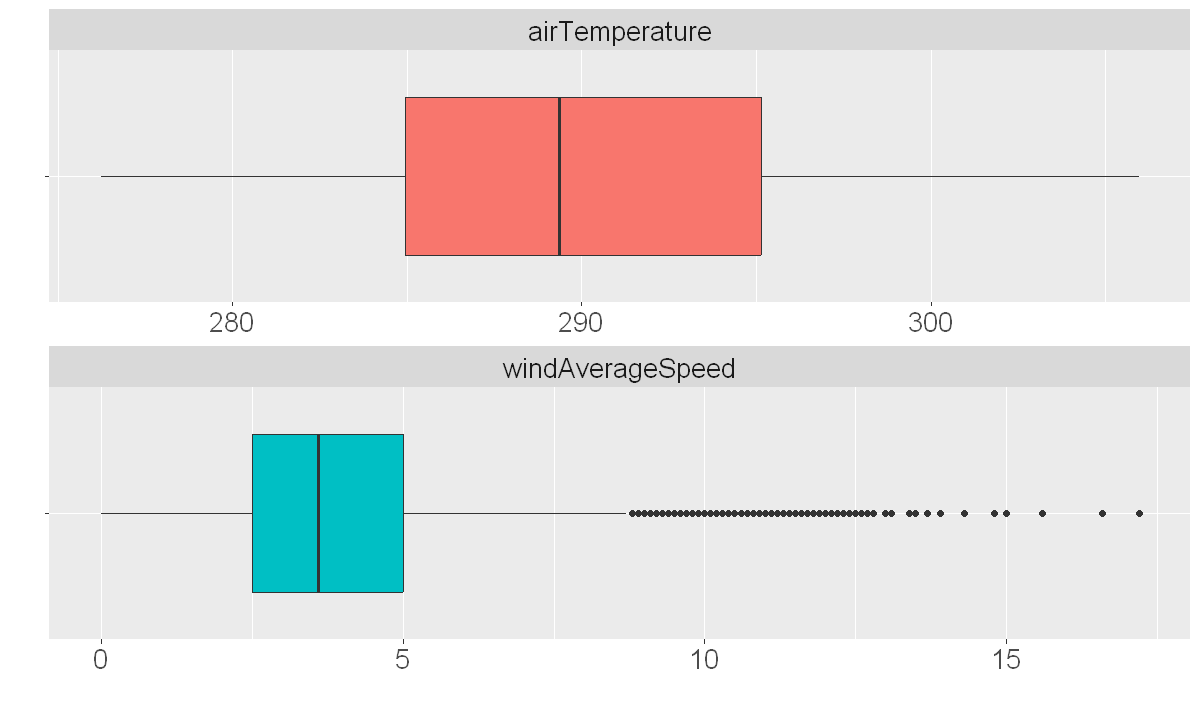

In [66]:
options(repr.plot.width = 10)
options(repr.plot.height = 6)
options(repr.plot.align = 'left')

ggplot(weather_data.long) +
    geom_boxplot( aes(x=value, y=id, fill=id), notch=FALSE, coef=1.5 ) +
    theme(text = element_text(size=20), 
          axis.text.y=element_blank()  , 
          legend.position="none" ) +
    #geom_jitter(color="black", size=0.4, alpha=0.9) +
    ylab("") +
    xlab("") +
    facet_wrap(~id, nrow = 2, #length(column.labels) , 
               scales = "free",
               shrink=FALSE,
               strip.position = "top") 
               #labeller = as_labeller(column.labels) ) 



TODD:
- outliers analysis

We can see that temperature data does not have any outliers but the wind speed data contains quite a few.

In [67]:
drop.outliers <- TRUE

prop.names <- unique(weather_data.long$id)

if (drop.outliers) {
    outliers <- boxplot(weather_data.wide$windAverageSpeed, plot=FALSE)$out
    outliers_rows <- which(weather_data.wide$windAverageSpeed %in% outliers)
        
    print(sprintf ("Removing %d outliers",  length(outliers_rows)) )
    weather_data.wide <- weather_data.wide[-outliers_rows ,]

    # reshape to a "long" format
    weather_data.long <- ts_long(weather_data.wide )

    print("After dropping outliers")
    print(paste('Wide format rows:', nrow(weather_data.wide)))
    print(paste('Long format rows:', nrow(weather_data.long)))
}

[1] "Removing 151 outliers"
[1] "After dropping outliers"
[1] "Wide format rows: 2766"
[1] "Long format rows: 5532"


### Simple linear regression

Let's build a linear regression model to check out our intuition that there is a relationsip between `airTemperature` and `windAverageSpeed`. 

In [68]:
temp.wind.lm <- lm(airTemperature ~ windAverageSpeed, data = weather_data.wide)

summary(temp.wind.lm)


Call:
lm(formula = airTemperature ~ windAverageSpeed, data = weather_data.wide)

Residuals:
     Min       1Q   Median       3Q      Max 
-14.3846  -4.9810  -0.3776   5.0146  17.0314 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      293.44255    0.26685 1099.64   <2e-16 ***
windAverageSpeed  -1.00347    0.06628  -15.14   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 5.88 on 2764 degrees of freedom
Multiple R-squared:  0.07658,	Adjusted R-squared:  0.07624 
F-statistic: 229.2 on 1 and 2764 DF,  p-value: < 2.2e-16


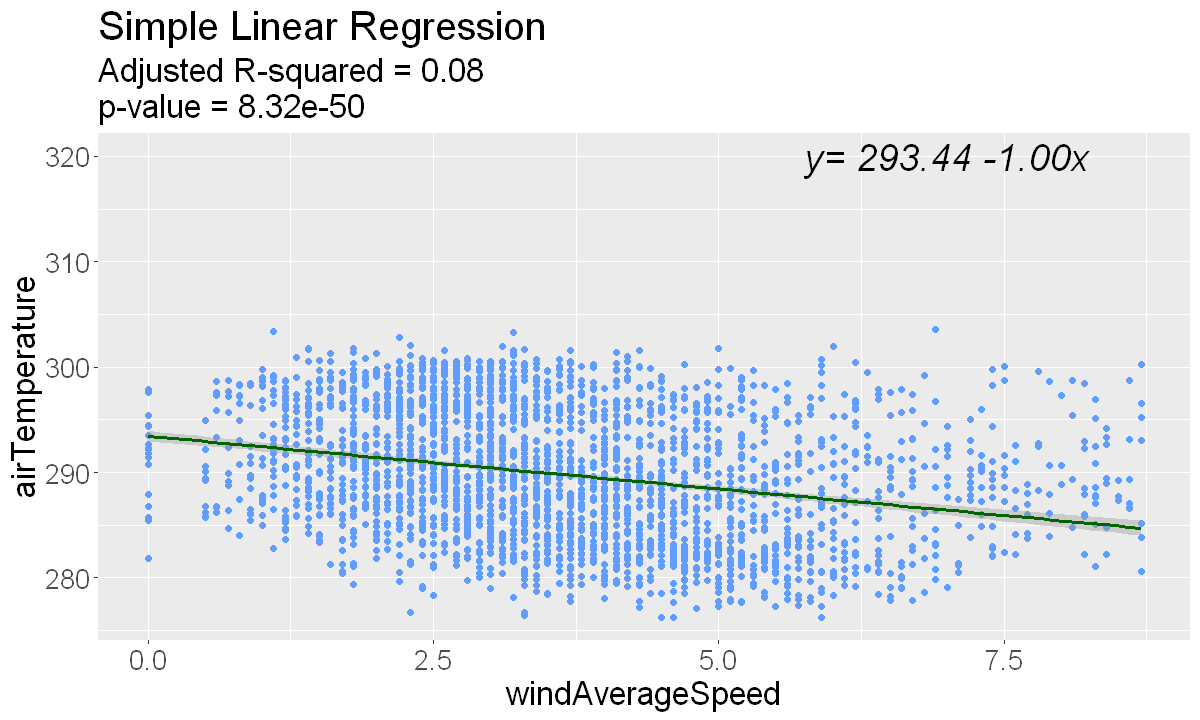

In [69]:
lm.quality <- sprintf("Adjusted R-squared = %.2f\np-value = %.2e", summary(temp.wind.lm)$adj.r.squared, 
                                                                  summary(temp.wind.lm)$coef[2,4] )

lm.formula <- sprintf("y= %.2f %.2fx", temp.wind.lm$coef[[1]], temp.wind.lm$coef[[2]])


ggplot(temp.wind.lm$model , aes(x=windAverageSpeed, y=airTemperature )) + 
       geom_point(color=column.colors[["windAverageSpeed"]]) +
       stat_smooth(method = "lm", color="darkgreen", formula=y ~ x) +
       annotate("text", x=7, y=320, label= lm.formula , size = 8, fontface = "italic") +
       theme(text = element_text(size=20)) +
       ggtitle(label= "Simple Linear Regression", subtitle=lm.quality) 

OBSERVATIONS AND CONCLUSIONS:

---

We built a Linear Regression with and without removing outliers. We found a significant relationship between `airTemperature` and `windAverageSpeed` in both cases with p-value << 0.001. However, removing outliers shows a stronger effect of wind speed  on the temperature. 

- with outliers: ~ 0.5 degrees decrease in air temperature for every 1 m/sec increase of wind speed 
- without outliers: ~ 1.0 degree decrease in air temperature for every 1 m/sec increase of wind speed
- the coefficient of determination (R2) is a low 0.08 which means that wind speed can explain only 8% of the variance in the air temperature values. 

This corresponds to our common sense knowledge that the weather is a complex system and the temperature depends on many more weather factors.

Let's see if this linear model works well to describe the relationship between `windAverageSpeed` and `airTemperature` and meets the assumptions of linear regression.

For univariate LR the data should meet the following assumptions:

1. Linearity of the data 
2. Normality of residuals 
3. Homogeneity of residuals variance (homoscedasticity) 
    
It is very easy to do in R by just plotting the diagnostics plots of LR.

| Assumption          | Plot              | What should we see |
| :----               | :----             | :---       |
| __Linearity__       |Residual vs. Fitted| There should be a straight red line close to 0.|
| __Normality__       |Normal Q-Q         | The normal probability plot of residuals should approximately follow a straight line.|
| __Homoscedasticity__|Scale-Location     | The residuals should be equally spread along a horizontal red line.  |


The fourth _Residuals vs Leverage_ plot can help to detect the outliers. Look for the points that are above and below 3 standard deviations on this plot.  

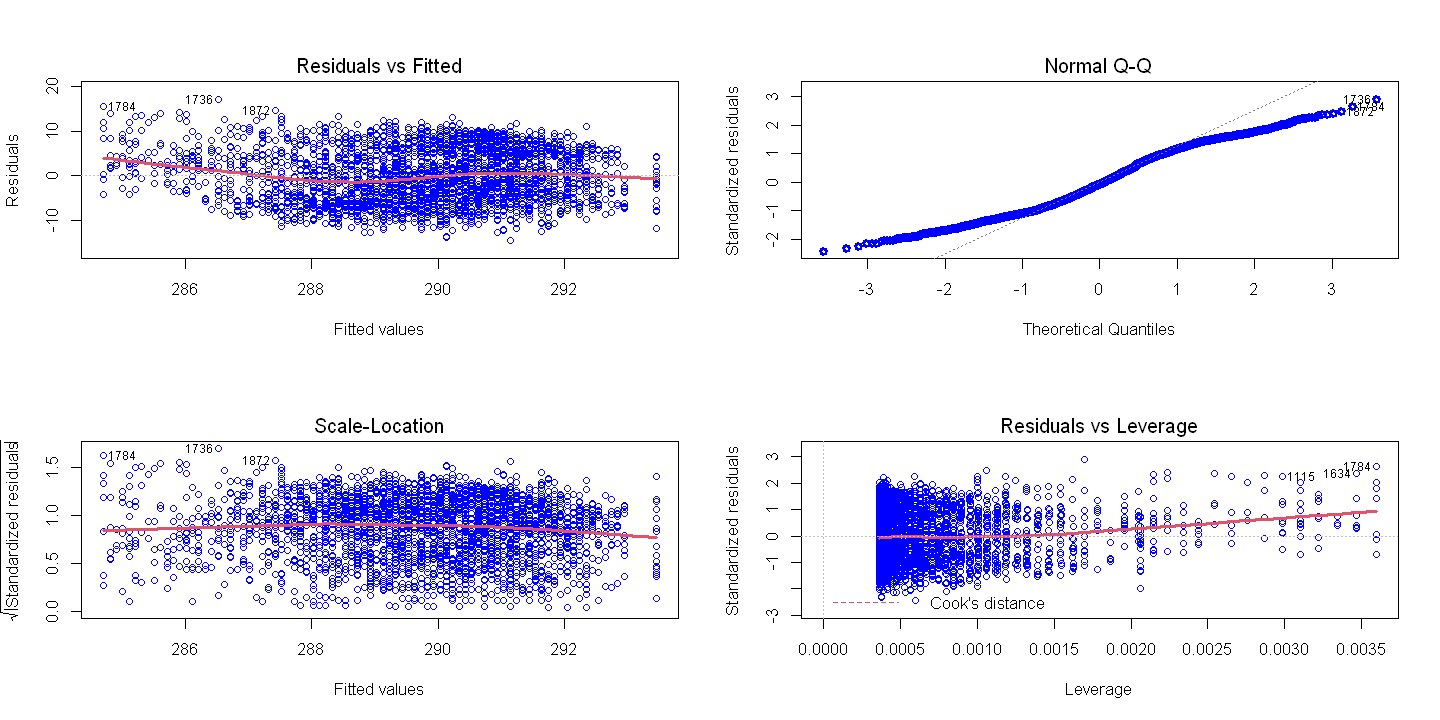

In [70]:
options(repr.plot.width = 12)
options(repr.plot.height = 6)

par(mfrow=c(2,2))
plot(temp.wind.lm, col = "blue" , lwd=3)
par(mfrow=c(1,1))

OBSERVATIONS AND CONCLUSIONS 

---

By looking at the diagnostics plot, we can see that our regression model meets the linear regression assumptions. 

- __[x] Linearity of the data__
- __[x] Normality of residuals__
- __[x] Homoscedasticity__

## Variable selection and multivariate regression

As we can see, one weather factor cannot explain the temperature variation. The WeKG contains many weather properties collected over the years. We can try discovering what other weather factors may influence the air temperature.

The idea of variable selection is to find the "best" set of weather properties that can be used to estimate the air temperature.  

### Query data for all weather properties for one year

At first, we query the wether properties values for 2016
- excluding aggregated properties *minAirTemperature* and *maxAirTemperature*
- excluding *cloudBaseAltidude* and *totalCloudCover* that do not have enough observations
- excluding measurements cumulative/differential observations over 12 hours in the cases of *percipitationAmount* and *differentialPressure*. 

We use FROM clause to select data only from 2016
We use FILTER clause of the SPARQL query to exclude properties

In [71]:
query_all_properties_data <- '
SELECT ?prop  ?time ?value 
       #?interval

FROM <http://ns.inria.fr/meteo/observation/2016>
FROM <http://ns.inria.fr/meteo/weatherstation>

WHERE {
    VALUES (?stationName) {("%s")}

    ?stationIRI rdfs:label ?stationName.

    ?obs a weo:MeteorologicalObservation;
          wep:madeByStation  ?stationIRI;  
          sosa:observedProperty ?prop ;
          sosa:resultTime ?time ;
          sosa:hasSimpleResult ?value.

     OPTIONAL { ?obs sosa:phenomenonTime [ a ?interval ]. }

     FILTER (?prop NOT IN (wevp:minAirTemperature, wevp:maxAirTemperature, 
                           wevp:cloudBaseAltitude, wevp:totalCloudCover) )

     FILTER (?interval != weo:Interval24h || !BOUND(?interval) )

}
ORDER BY ?time ?prop ?value
'

query_all_properties_data <- sprintf( query_all_properties_data, station_name)
query_all_properties_data <- paste(sparql_prefix, query_all_properties_data)

weather_data_all <- SPARQL(url= endpoint,
                          query = query_all_properties_data,
                          ns=data_prefix,
                          extra=NULL)$results

# convert date from numeric representation returned from query to R's date format
weather_data_all$time <- as.POSIXct(weather_data_all$time, origin="1970-01-01")

# remove prefix from the property names to make life easier 
# when property names will become column names
weather_data_all$prop <- sapply(weather_data_all$prop, FUN=function(x) gsub("^.*?:", "", x) )

print(paste('Result rows:', nrow(weather_data_all)))

[1] "Result rows: 40731"


### Data wrangling

We can perform some basic data manipulations like excluding duplicates, outliers, and missing values. 

In [72]:
options(width=80)

# Turn on deduplication if ts_wide function complains about the duplicates 
deduplicate <- FALSE

if (deduplicate) {
    weather_data_all.dedup <-  weather_data_all[ !duplicated(weather_data_all[, c("time", "prop")]), ]
    
    print(paste('Deduplicated rows:', nrow(weather_data_all.dedup)))
}

weather_data_all.wide <- ts_wide(weather_data_all)
print(paste('Wide format rows :', nrow(weather_data_all.wide)))

# We can instruct the analysis functions simply not to use the missing values
# To explicitly remove the missing values turn on 
drop.missing <-TRUE

if (drop.missing) {
   weather_data_all.wide <- na.omit(weather_data_all.wide)

   print("After removing missing values")
   print(paste('Wide format rows :', nrow(weather_data_all.wide)))
}

# We can try to select features with or vthout removing the outliers
# here will concider the outliers the values that are beyond 3 standard deviations 
# for a property ditribution
drop.outliers <- TRUE

if (drop.outliers) {
    prop.names <- unique(weather_data_all$prop)
    outliers_rows <- c()
    for (p in  prop.names) {
       bp <- boxplot(weather_data_all.wide[, p], plot=FALSE)
       outliers <- bp$out
                
       if (bp$stats[2] < bp$stats[4]) {
          print(sprintf ("Removing %d %s outliers",  length(outliers), p) )
          outliers_rows <- c(outliers_rows ,  which(weather_data_all.wide[ ,p] %in% outliers))
       }
    }

    if (length(outliers_rows) > 0) {
          weather_data_all.wide <- weather_data_all.wide[-outliers_rows ,]
    }
   print("After removing outliers")
   print(paste('Wide format rows :', nrow(weather_data_all.wide)))
}

summary(weather_data_all.wide)

[1] "Wide format rows : 2922"
[1] "After removing missing values"
[1] "Wide format rows : 2826"
[1] "Removing 35 airRelativeHumidity outliers"
[1] "Removing 0 airTemperature outliers"
[1] "Removing 9 dewPointTemperature outliers"
[1] "Removing 77 differentialPressure outliers"
[1] "Removing 164 gustSpeed outliers"
[1] "Removing 0 horizontalVisibility outliers"
[1] "Removing 140 lowCloudCover outliers"
[1] "Removing 0 minSoilTemperature outliers"
[1] "Removing 150 seaLevelPressure outliers"
[1] "Removing 149 stationPressure outliers"
[1] "Removing 0 windAverageDirection outliers"
[1] "Removing 148 windAverageSpeed outliers"
[1] "After removing outliers"
[1] "Wide format rows : 2362"


      time                     airRelativeHumidity airTemperature 
 Min.   :2016-01-01 12:00:00   Min.   :29.00       Min.   :276.2  
 1st Qu.:2016-04-14 12:45:00   1st Qu.:57.00       1st Qu.:285.4  
 Median :2016-07-13 18:00:00   Median :68.00       Median :289.9  
 Mean   :2016-07-08 14:42:49   Mean   :66.21       Mean   :290.2  
 3rd Qu.:2016-09-30 23:15:00   3rd Qu.:76.00       3rd Qu.:295.6  
 Max.   :2016-12-31 21:00:00   Max.   :93.00       Max.   :303.6  
 dewPointTemperature differentialPressure   gustSpeed      horizontalVisibility
 Min.   :262.9       Min.   :-240.000     Min.   : 0.000   Min.   : 1820       
 1st Qu.:278.6       1st Qu.: -60.000     1st Qu.: 3.200   1st Qu.:25000       
 Median :284.1       Median :   0.000     Median : 4.500   Median :30000       
 Mean   :283.6       Mean   :   2.815     Mean   : 4.804   Mean   :33854       
 3rd Qu.:288.6       3rd Qu.:  60.000     3rd Qu.: 6.100   3rd Qu.:40000       
 Max.   :295.9       Max.   : 240.000     Max.   :1

### Correlation analysis
Let's perform a correlation analysis of the weather properties to discover their pair-wise relationship and how strong this relationship may be. 

We calculate the Pearson correlation coefficient (r), which measures a linear dependence between two variables. The rule of thumb for interpreting the strength of the relationship between two variables is based on the value of r:

| Absolute value of r | Strength of relationship |
| :----:              | :----                    |
|        r < 0.25     | No relationship          |
| 0.25 < r < 0.5      | Weak relationship        |
| 0.5  < r < 0.75     | Moderate relationship    |
| 0.75 < r            | Strong relationship      |



In [73]:
# drop non-numeric time column
weather_data_all.wide.cor <- subset(weather_data_all.wide, select = -c( time ) )

# missing values are removed by use = "complete.obs"
r <- cor(weather_data_all.wide.cor, method = "pearson", use = "complete.obs")

#round(r, 2)

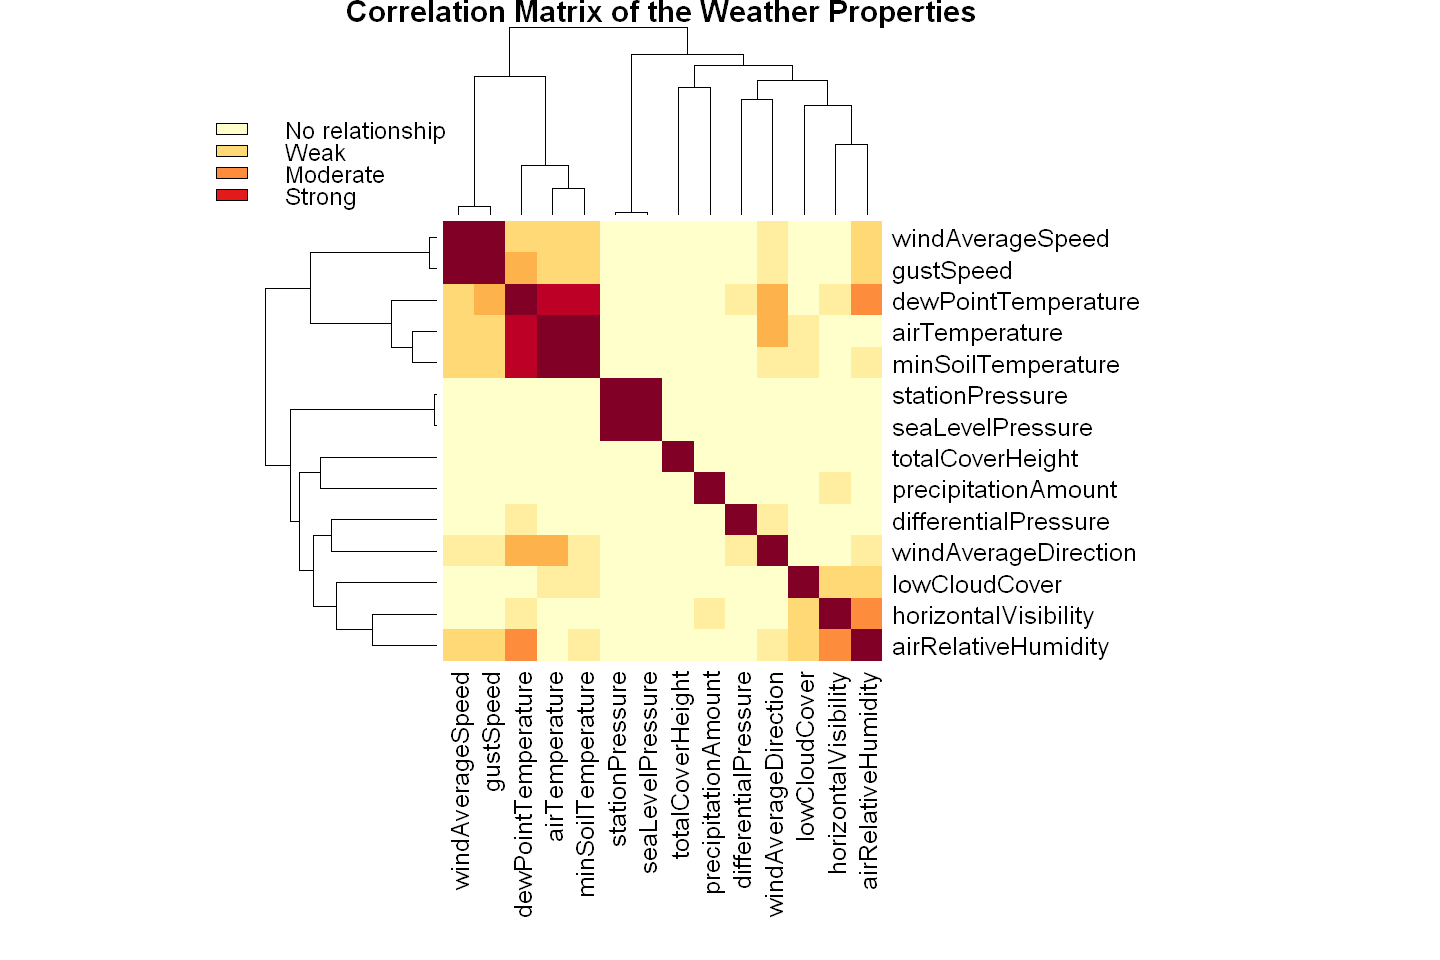

In [74]:
options(repr.plot.width = 12)
options(repr.plot.height = 8)
options(repr.plot.align = 'left')

col <- brewer.pal(9, "YlOrRd")

par(mfrow=c(2,1))

# replace NA with 0 because for a straight line cor function sets te corelation to NA
# it seems that the heatmap's na.rm does not work
r[is.na(r)] <- 0

heatmap(x = abs(r),  symm = TRUE,
        margins = c(15,15), 
        main="Correlation Matrix of the Weather Properties",
        cexCol=1.5,
        cexRow = 1.5,
        col=col,
        na.rm=TRUE)

par(mfrow=c(1,1))      

leg.col <- col[c(1, 3,5,7)]
legend(0,1.3, #x="bottomleft", 
       legend=c("No relationship", "Weak", "Moderate", "Strong"),
       fill=leg.col,
       bty="n",
       cex=1.2,
       )


- TODO: plot with corrplot https://statsandr.com/blog/correlation-coefficient-and-correlation-test-in-r/#correlation-matrix-correlations-for-all-variables

- more visualization tools here http://www.sthda.com/english/wiki/correlation-matrix-a-quick-start-guide-to-analyze-format-and-visualize-a-correlation-matrix-using-r-software


OBSERVATIONS AND CONCLUSIONS

---



From the heatmap of the correlation matrix we can tell that *airTemperature* has 
- strong relationships with *minSoilTemperature* and *dewPointTemperature*
- weak relationships with *windAverageDirection*, *gustSpeed*, and *windAverageSpeed* 
- we also see the obvious strong correlation between the wind speeds *windAverageSpeed* and *gustSpeed* however it is surprising to see a weak relationship between *airRealtiveHumidity* and wind speed
- we see the relation between visibility and cloud cover  
- we see the relation between the pressure properties

This shows us that in this set of properties if we want to do a linear regression to model one property dependency on another and if we choose to use all of the properties we will violate the fourth assumption of linear regression _independence_. 

To build a good multivariate regression we need to select the independent variables (predictors).

### Feature selection with LASSO


The LASSO (Least Absolute Shrinkage and Selection Operator) model is used for the selection and reduction of parameters for regression. It can determine a minimal number of variables that gives the largest predictive power. This method helps to deal with _multicollinearity_.

We can use the 10-fold cross-validation method of the `glmnet` package to determine  the best hyperparameter λ and fit the LASSO regression.

In [75]:
# split the data on dependent and independent variables 
# and scale the data
weather_data_all.wide.lasso.x <- scale(subset(weather_data_all.wide, select = -c( time, airTemperature, totalCoverHeight ) ))
weather_data_all.wide.lasso.y <- scale(weather_data_all.wide$airTemperature)

In [76]:
options(repr.plot.width = 12)
options(repr.plot.height = 6)
options(repr.plot.align = 'left')

# finding the best hyperparameter with 10 fold cross-validattion
set.seed(42)
temp.all.lasso.cv <- cv.glmnet(weather_data_all.wide.lasso.x,
                         weather_data_all.wide.lasso.y, 
                         alpha=1, # LASSO
                         family = "gaussian",
                         nfold=10)

#plot(temp.all.lasso.cv)

temp.all.lasso.cv

coef(temp.all.lasso.cv, s=c(temp.all.lasso.cv$lambda.min ,temp.all.lasso.cv$lambda.1se ))


Call:  cv.glmnet(x = weather_data_all.wide.lasso.x, y = weather_data_all.wide.lasso.y,      nfolds = 10, alpha = 1, family = "gaussian") 

Measure: Mean-Squared Error 

      Lambda Index  Measure        SE Nonzero
min 0.001948    67 0.004137 0.0002960       8
1se 0.006529    54 0.004390 0.0003373       4

13 x 2 sparse Matrix of class "dgCMatrix"
                                s1            s2
(Intercept)          -7.210549e-15 -7.120839e-15
airRelativeHumidity  -5.136015e-01 -4.996137e-01
dewPointTemperature   1.113908e+00  1.095478e+00
differentialPressure  .             .           
gustSpeed             .             .           
horizontalVisibility -1.745967e-03  .           
lowCloudCover         .             .           
minSoilTemperature    3.381733e-02  4.388677e-02
precipitationAmount   2.757965e-03  .           
seaLevelPressure     -2.214990e-03  .           
stationPressure       .             .           
windAverageDirection -1.743059e-03 -1.169405e-03
windAverageSpeed     -3.437753e-03  .           

We have two models selected:

- the model that produced a minimum MSE at `λ=0.002` with 8 non-zero variables 
- the model that produced MSE within 1 standard deviation at `λ=0.007` with 4 non-zero variables

We'll take the lesser number of variables and build a linear regression to see how adding multiple variables improved air temperature regression. 

Multivariate linear regression has another assumption that the predictor variables are __independent__. We can visualize the correlation matrix to confirm that.

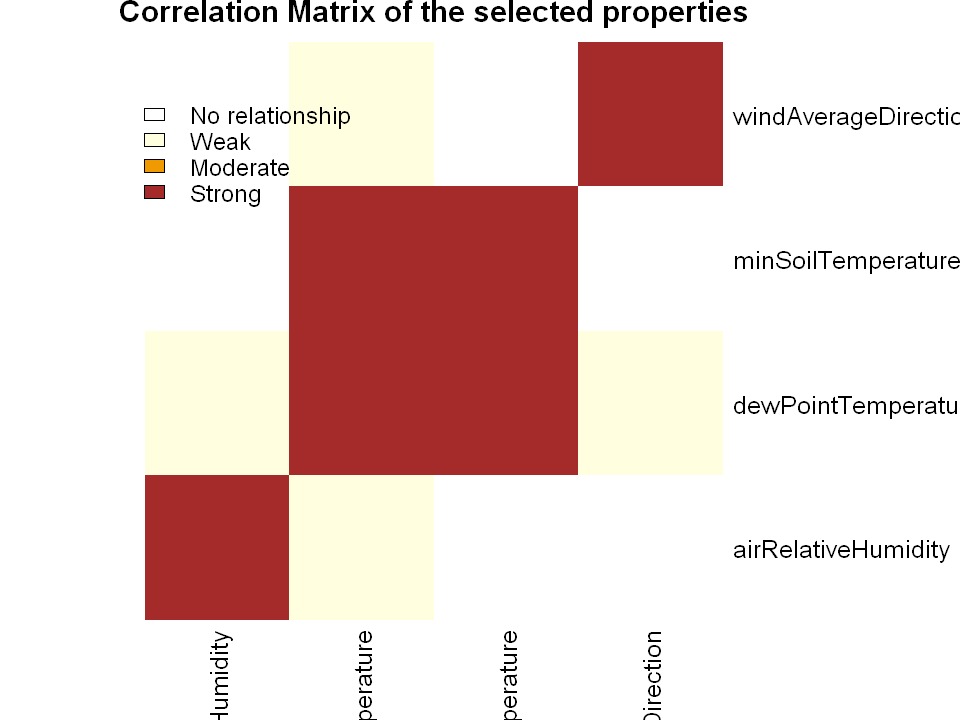

In [77]:
options(repr.plot.width = 8)
options(repr.plot.height = 6)

r.selected <- cor(weather_data_all.wide[, c('airRelativeHumidity', 'dewPointTemperature' ,
                                             'minSoilTemperature', 'windAverageDirection')], 
          method = "pearson", use = "complete.obs")

col <- c('white', 'lightyellow', 'orange2', 'brown')

heatmap(x = abs(r.selected), 
        symm=TRUE, 
        Rowv = NA, Colv = NA,  
        margines=c(12,12),
        cexCol=1.5,
        cexRow = 1.5,
        col=col,
        main="Correlation Matrix of the selected properties")

legend(x="topleft", 
       legend=c("No relationship", "Weak", "Moderate", "Strong"),
       fill=col,
       bty="n",
       cex=1.2,
       )

We see that _dewPointTemperature_ and _minSoilTemperature_ are strongly correlated. so we can take only one of them. 

In [78]:
temp.multi.lm <- lm(airTemperature ~ airRelativeHumidity  + 
                                     minSoilTemperature + #dewPointTemperature +
                                     windAverageDirection ,
                            data = weather_data_all.wide)

summary(temp.multi.lm)


Call:
lm(formula = airTemperature ~ airRelativeHumidity + minSoilTemperature + 
    windAverageDirection, data = weather_data_all.wide)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.5060 -1.3715 -0.0285  1.4312  6.5760 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)          77.1844749  1.8344028   42.08   <2e-16 ***
airRelativeHumidity  -0.0776083  0.0035166  -22.07   <2e-16 ***
minSoilTemperature    0.7684784  0.0063984  120.11   <2e-16 ***
windAverageDirection -0.0120653  0.0004119  -29.29   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.089 on 2358 degrees of freedom
Multiple R-squared:   0.88,	Adjusted R-squared:  0.8799 
F-statistic:  5764 on 3 and 2358 DF,  p-value: < 2.2e-16


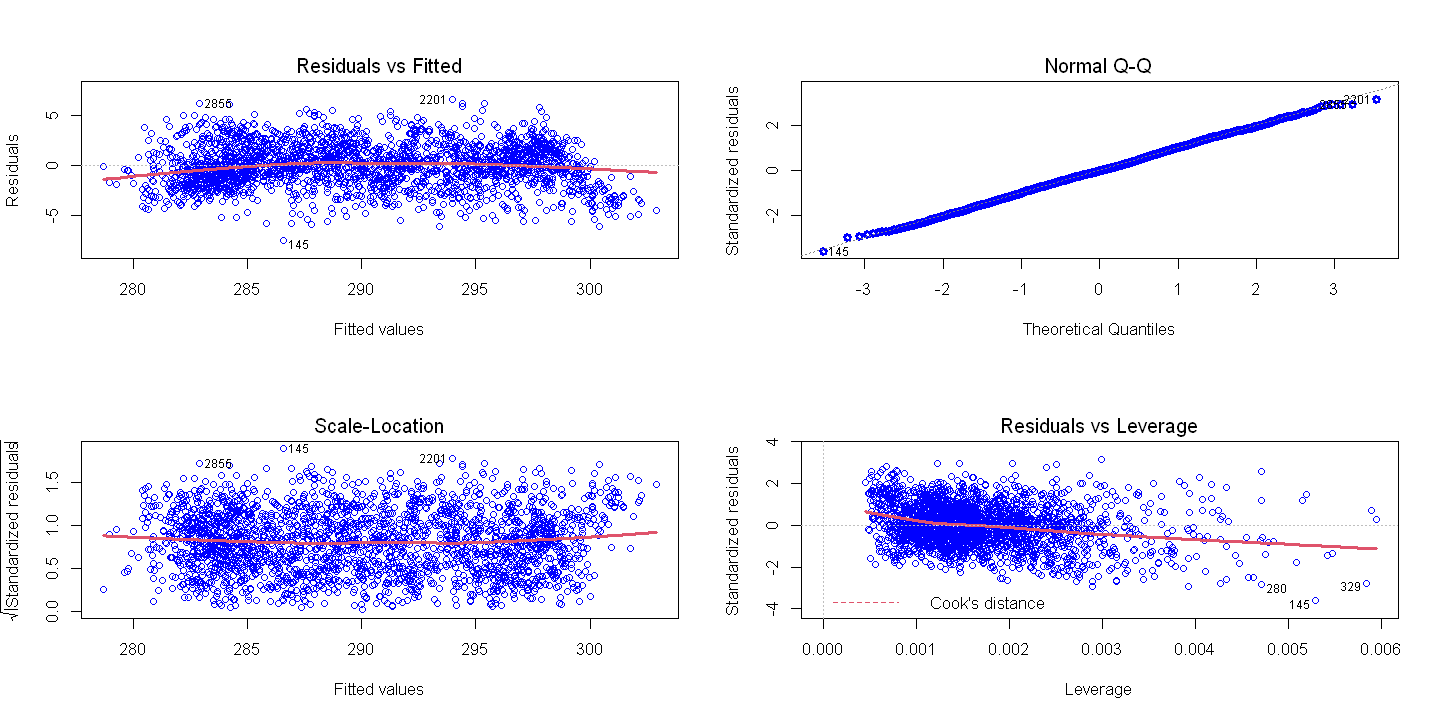

In [79]:
options(repr.plot.width = 12)
options(repr.plot.height = 6)

par(mfrow=c(2,2))
plot(temp.multi.lm, col = "blue" , lwd=3)
par(mfrow=c(1,1))

OBSERVATIONS AND CONCLUSIONS

---

- __[x] Linearity of the data__
- __[x] Normality of residuals__
- __[x] Homoscedasticity__
- __[x] Independence__

By including weather properties selected by LASSO into regression to model _airTemperature_ relations with other weather properties we've increased the coefficient of determination (R2) value to almost 0.88 which means that the selected properties can explain 88% of the variation in the air temperature. 

The p-values for pre-selected variables are very low. 

So we can tell that the major factors that affect the temperature are humidity, soil temperature, and wind. 

## Principal Component Analisys (PCA)

Principal Component Analysis (PCA) is a useful technique for exploratory data analysis, allowing you to better visualize the variation present in a dataset with many variables.

The first principal component (PC1) explains the most variance in the data, the second principal component (PC2) explains the second most variance, and so on. The loading of the eigenvector represents how important each original variable is to the component.

We have 15 different weather properties and we want visualize the variation and correlation between the these variables.

NOTE: for visualization clarity we average the numeric data monthly.

### Aggregating data

For visualization clarity we average the numeric data monthly.

In [80]:
#delete non-numeric columns and contant column
weather_data_all.wide.pca <- weather_data_all.wide
weather_data_all.wide.pca$month <-as.numeric(format(as.Date(weather_data_all.wide.pca$time, format="%d/%m/%Y"),"%m") )
weather_data_all.wide.pca <- aggregate( weather_data_all.wide.pca, by=list(month = weather_data_all.wide.pca$month) , mean )
weather_data_all.wide.pca <- subset(weather_data_all.wide.pca, select = -c( time , month, totalCoverHeight) )

summary(weather_data_all.wide.pca)

 airRelativeHumidity airTemperature  dewPointTemperature differentialPressure
 Min.   :62.63       Min.   :282.4   Min.   :275.4       Min.   :-2.7619     
 1st Qu.:63.42       1st Qu.:284.4   1st Qu.:277.5       1st Qu.: 0.4574     
 Median :65.18       Median :289.4   Median :282.7       Median : 1.9679     
 Mean   :66.09       Mean   :289.6   Mean   :283.0       Mean   : 2.9865     
 3rd Qu.:67.59       3rd Qu.:294.5   3rd Qu.:288.6       3rd Qu.: 6.3641     
 Max.   :75.28       Max.   :297.9   Max.   :291.3       Max.   :11.9251     
   gustSpeed     horizontalVisibility lowCloudCover   minSoilTemperature
 Min.   :3.872   Min.   :29636        Min.   :1.064   Min.   :278.4     
 1st Qu.:4.417   1st Qu.:31652        1st Qu.:1.535   1st Qu.:280.2     
 Median :4.793   Median :34343        Median :2.030   Median :286.3     
 Mean   :4.841   Mean   :33737        Mean   :2.045   Mean   :286.9     
 3rd Qu.:5.212   3rd Qu.:35115        3rd Qu.:2.240   3rd Qu.:293.2     
 Max.   :6.308  

### PCA

In [81]:
pca <- prcomp(weather_data_all.wide.pca, #[1:100, ], 
              center=TRUE,  scale.=TRUE,
              rank. = 6, na.rm = TRUE)

In [82]:
options(width=100)
summary(pca)
pca

Importance of first k=6 (out of 12) components:
                         PC1    PC2    PC3    PC4     PC5     PC6
Standard deviation     2.538 1.7847 1.2589 1.2145 0.74886 0.58555
Proportion of Variance 0.460 0.2275 0.1132 0.1053 0.04006 0.02449
Cumulative Proportion  0.460 0.6875 0.8007 0.9060 0.94607 0.97056

Standard deviations (1, .., p=12):
 [1] 2.537566e+00 1.784737e+00 1.258851e+00 1.214474e+00 7.488594e-01 5.855459e-01 4.953494e-01
 [8] 3.098628e-01 2.367399e-01 1.163136e-01 3.462726e-02 8.915846e-15

Rotation (n x k) = (14 x 6):
                             PC1         PC2          PC3          PC4         PC5           PC6
airRelativeHumidity  -0.23349314 -0.11628896  0.013480682 -0.522698211  0.44959422 -4.733640e-01
airTemperature       -0.33861305  0.26433469 -0.007080497 -0.010956789 -0.19632274  1.549160e-01
dewPointTemperature  -0.35171373  0.23387415 -0.008597190 -0.087144152 -0.11546624  6.598678e-02
differentialPressure  0.13719585 -0.14958299  0.604075649  0.010931867 -0.46848610 -5.354873e-01
gustSpeed             0.37021543  0.11320745  0.025594866  0.046602252  0.25968430  3.382057e-02
horizontalVisibility  0.02536971  0.30411424  0.248011180  0.536119839  0.39009505 -7.520730e-02
lowCloudCover         0.22595076 -0.34432945 -0.195462845 -0.326254772  0.04156460  2.1471

In [83]:
if (!require(ggbiplot)) {
  library(devtools)
  install_github("vqv/ggbiplot")
}
library(ggbiplot)

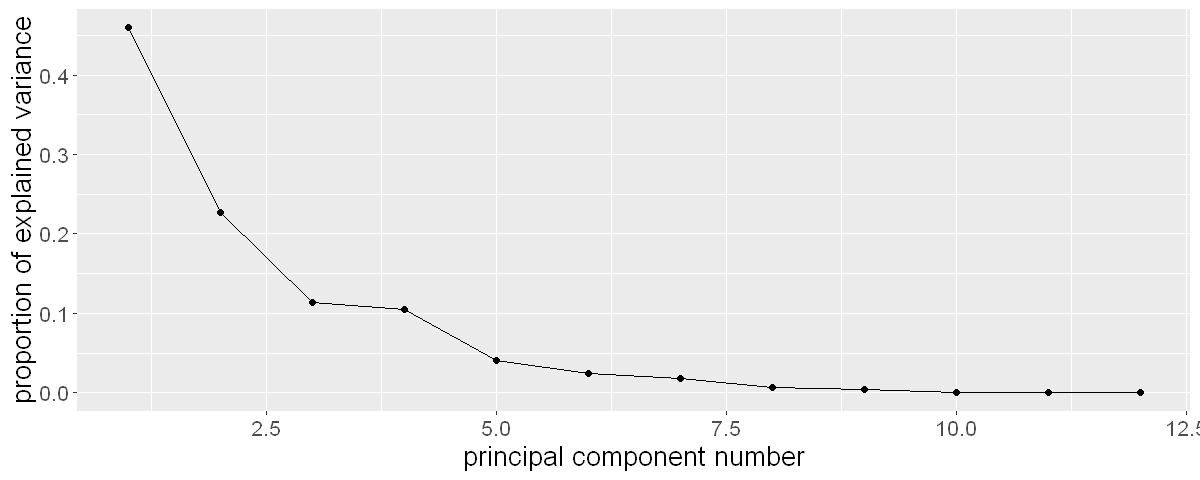

In [84]:
#probably delete
options(repr.plot.width = 10)
options(repr.plot.height = 4)

#screeplot(pca); box()
ggscreeplot(pca) +
  theme(text = element_text(size = 16))  

### Visualize reesults

For more appealing plot we group the data into the seasons. 

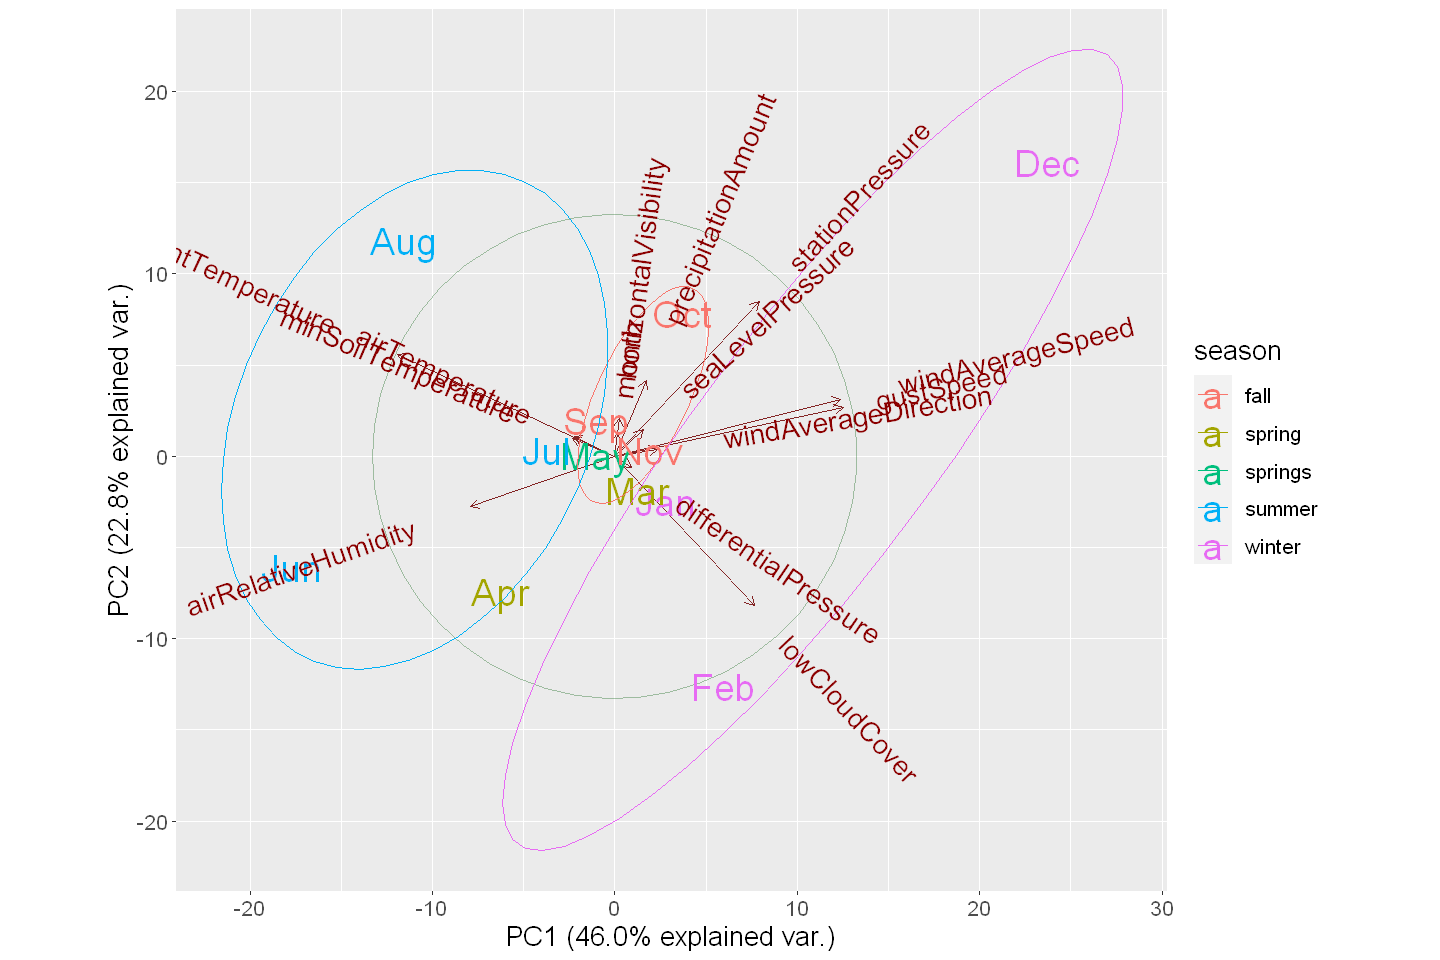

In [85]:
options(repr.plot.width = 12)
options(repr.plot.height = 8)
options(repr.plot.align = "left")

season <- c("winter", "winter", "spring", "spring", "springs", "summer", "summer", "summer", "fall", "fall", "fall", "winter")

ggbiplot(pca,
         obs.scale = 1, var.scale = 1, 
         varname.size = 6,
         groups = season,
         labels=month.abb[1:12],
         labels.size=8,
         circle = TRUE,
         ellipse = TRUE) +
     scale_color_discrete(name = 'season') +
     theme(text = element_text(size = 16))  

OBSERVATIONS AND CONCLUSIONS

---

- PC1 has a larger positive loading on wind measurements ( _gustSpeed_, _windAverageSpeed_, _WindAverageDirrection)  and a larger negative loading on temperature measurements (_airTemperature_, _dewPointTemperature_, _min_soilTemperature_)  which shows that the temperatures and the wind are negatively correlated

- we also see what we've seen before that the _dewPointTemperature_ and  _min_soilTemperature_ are very closely correlated 

- PC2 has negative loading on _cloudCover_, and positive loading on pressure measurements (_stationPresssure_, _seeLevelPressure) which are also close to each other and only one can be considered

- PC3 has strong positive loading on _diffirentialPressure_ and explains another portion of the variance

- we can see that PCA captured the difference between the winter and the summer in Nice, however, as expected, spring and fall are barely distinguishable. 

- the first three components explain over 80% of the total variance, we might consider keeping only these three components and reducing our data dimensionality from 13 to just 3.
